# Final Report: Uncovering Organizational Structures Through Facebook Friendship Networks

## Author: David Mateo Carpio Rivas

This notebook contains a comprehensive analysis of the L2 network, a real-world social network extracted from Facebook using friendships of users who indicated on their Facebook profiles that they worked for the L2 organization. The study examines its structural properties, centrality measures, community detection, and comparisons with theoretical models (Erdős-Rényi and Barabási-Albert).

## Libraries

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import time
from collections import deque
import pickle
from scipy.linalg import expm
import scipy.stats as stats
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error 
from scipy.special import erf
from scipy.special import erfc
from scipy.stats import ks_2samp, chisquare
from networkx.algorithms import community
from scipy.interpolate import interp1d
from matplotlib.ticker import AutoMinorLocator
from networkx.algorithms import community
from community import community_louvain
import networkx.algorithms.community as nx_comm

#Colors
blues = plt.colormaps['Blues']
cmap1 = blues(np.linspace(0.0, 1, 10))
greys = plt.colormaps['Greys']
cmap2 = greys(np.linspace(0.0, 1, 10))

## Upload Network

In [3]:
# Load the newly provided CSV files
edges_file = "networks/L2.csv/edges.csv"
nodes_file = "networks/L2.csv/nodes.csv"

# Read the data into DataFrames
edges = pd.read_csv(edges_file)
nodes = pd.read_csv(nodes_file)

# Create the graph
G = nx.Graph()

# Add nodes with attributes from the new file
for _, row in nodes.iterrows():
    G.add_node(row['# index'], name=row.get(' name', None), pos=np.array(eval( row.get(' _pos', None).split('array(')[1].rstrip(')')  ) )  )  # Add name if it exists

# Add edges from the new file
for _, row in edges.iterrows():
    G.add_edge(row['# source'], row[' target'])



# Part I Network Structural Analysis


## a) Number of nodes, links, network density, average degree.

### Number of nodes and links

In [5]:
n = len(G)
m = len(G.edges)
print(f"Total nodes = {n}. Total links = {m}")

Total nodes = 5524. Total links = 94219


### Average Degree and its variance

In [7]:
def degree(G, node):
    """
    Calculates the Degree of a node in a network G.

    Args:
        G: network.
        node: node i

    Returns:
        k_i: degree of node i  
    """
    ki = len(list(G.neighbors(node)))

    return ki
    

In [9]:
def degrees(G):
    """
    Calculates the Degree of all nodes in a network G.

    Args:
        G: network.

    Returns:
        k_is: array withe the degree of all nodes
    """
    N = len(G)
    kis = np.zeros(N)
    i = 0
    
    for node in G.nodes():
        kis[i] = degree(G,node)
        i += 1
    return kis

In [11]:
def average_degree(G):
    """
    Calculates the average degree in a network G.

    Args:
        G: network.

    Returns:
        k_ave: average_degree  
    """
    n = len(G)
    k = degrees(G)
    k_ave = sum(k)/n
    std = np.std(k)
    return k_ave, std

In [13]:
k_ave, std = average_degree(G)

In [15]:
print("Average degree =",k_ave, "Standar deviation of the degrees =",std)

Average degree = 34.112418537291816 Standar deviation of the degrees = 31.811125677784876


### Network Density

In [23]:
def density(m,n):
    delta =2*m/(n*n-1)
    return delta

def measure_density(G):
    n = len(G)
    k = degrees(G)
    m = sum(k)/2
    delta = density(m,n)
    return delta
    

In [29]:
delta = measure_density(G)
print("Edge density =", delta)

Edge density = 0.006175311306154518


## b) Average clustering coefficient of the nodes

In [118]:
def clustering_coefficient(G,n):
    """
    Calculate clustering coeficiente for each node in G

    Args:
        G: network
        n: node 
    Returns:
        dict: dictionary {node: c_i}.
    """
    clustering = np.zeros(n)  
    for node in G.nodes():
        neighbors = list(G.neighbors(node))  
        k = len(neighbors) 
        
        if k < 2: 
            clustering[node] = 0.0
            continue
        
        
        triangles = 0
        for i in range(len(neighbors)):
            for j in range(i + 1, len(neighbors)):
                if neighbors[j] in G.neighbors(neighbors[i]):
                    triangles += 1
        
        clustering[node] = (2 * triangles) / (k * (k - 1))
    
    return clustering


In [120]:
c_s = clustering_coefficient(G,n)

In [132]:
C = np.sum(c_s)/n
print(f"Average clustering coefficient (Watts-Strogatz): {C}")

Average clustering coefficient (Watts-Strogatz): 0.3610637649776439


### Using networkX

In [305]:
print(f"Average clustering coefficient using network X(Watts-Strogatz): {nx.average_clustering(G)}")

Average clustering coefficient using network X(Watts-Strogatz): 0.36105960364568807


## c) Global clustering coefficient (Newman transitivity)

In [137]:
def transitivity_index(G):
    """
    Calculate the transitivity index T:
    
    Args:
        G: the networks.

    Returns:
        T: transitivity index
    """
    triangles = 0 
    paths_length_2 = 0  

    for v in G.nodes():
        neighbors = list(G.neighbors(v))  
        k = len(neighbors)  
                
        paths_length_2 += k * (k - 1) / 2  
        
        for i in range(len(neighbors)):
            for j in range(i + 1, len(neighbors)):
                if neighbors[j] in G.neighbors(neighbors[i]):
                    triangles += 1
    
    if paths_length_2 == 0:
        return 0.0
    
    T = (triangles) / paths_length_2
    return T


In [141]:
T = transitivity_index(G)


In [143]:
print(f"Transitivity index: {T}")

Transitivity index: 0.22240102035537285


### Using networkX

In [145]:
print(f"Transitivity index by networkX: {nx.transitivity(G)}")

Transitivity index by networkX: 0.2223911602344453


## d) Average Path Length and Diameter

### Average Path Length

In [128]:
PL = nx.average_shortest_path_length(G)

In [129]:
print(f"Average shortest path length: {PL}")

Average shortest path length: 3.5038409584145715


### Diameter of the network

In [15]:
def bfs(G, start_node):
    """
    Perfomr BFS for a node
    
    Args:
        start node
        
    Returns: sets of minimum distances to each node in G
    """ 
    visited = {node: False for node in G.nodes()} 
    distance = {node: float(0) for node in G.nodes()} 
    queue = deque([start_node]) #Define a queue 
    visited[start_node] = True
    distance[start_node] = 0

    
    while queue: 
        node = queue.popleft() 
        for neighbor in G.neighbors(node):
            if not visited[neighbor]:
                visited[neighbor] = True
                distance[neighbor] = distance[node] + 1
                queue.append(neighbor)

    return distance


In [19]:
def calculate_diameter(G):
    """
    Calculate diameter of the network G.

    Args:
        G: Graph, undirected, and conex.

    Returns:
        int: diameter.
    """
    max_distance = 0 
    for node in G.nodes():
        distances = bfs(G, node) #extract all minimum distance for a node 
        farthest_distance = max(distances.values()) #Take the maximum distance
        max_distance = max(max_distance, farthest_distance) #Compare
    
    return max_distance


In [21]:
# Network X function
start = time.time()
# Calcular el diámetro
diameter = calculate_diameter(G)
print(f"Diameter of the grap (my function) is: {diameter}")
end = time.time()
print("time to compute=",end-start)

Diameter of the grap (my function) is: 9
time to compute= 256.76741003990173


In [161]:
start = time.time()
print(f"Diameter of the network using networkX {nx.diameter(G)}")
end = time.time()
print("time to compute=",end-start)

Diameter of the network using networkX 9
time to compute= 229.6033821105957


## e) Degree distribution of the network

### PDF (L2)

In [17]:
def degree_dist(G):
    k_s = list(degrees(G))
    k_max = max(k_s)
    #n_k = np.zeros(int(k_max))
    n_k = []
    #k_values = np.zeros(int(k_max))
    k_values = []
    for i in range(1, int(k_max)+1):
        count = k_s.count(i)
        if count != 0:
            n_k.append(count)
            k_values.append(i)
        #n_k[i-1] = k_s.count(i)
        #k_values[i-1] = i-1
    return n_k, k_values

In [19]:
k_s = degrees(G)
probabilities = k_s/n

In [21]:
n_k, k_values = degree_dist(G)

In [23]:
print("maximum value", max(k_s))

maximum value 417.0


#### Normal Scale

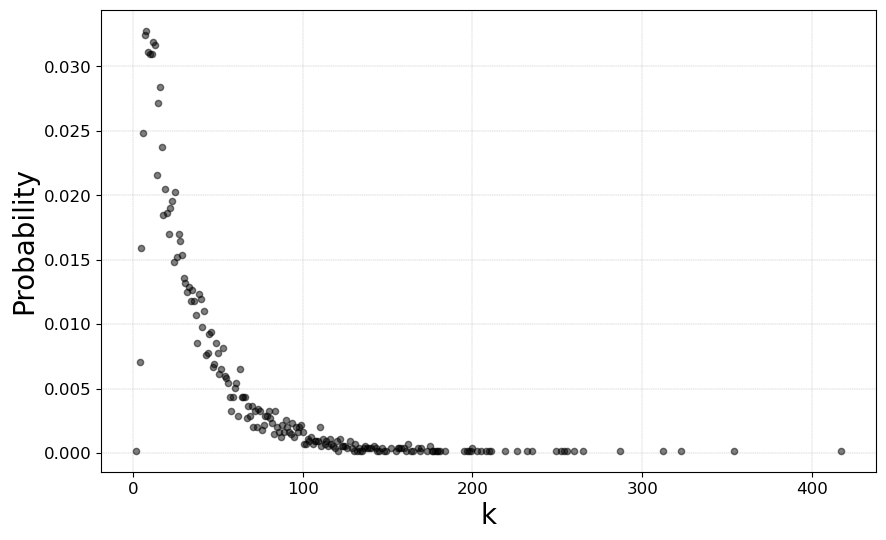

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, np.array(n_k)/n,linestyle='',marker = 'o',markersize=4.5,color=cmap2[9],alpha=0.5)
plt.xlabel('k', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(linestyle='--', linewidth=0.3)

# plt.savefig('figures/facebook_pdf.png', dpi=300, bbox_inches='tight')
plt.show() 

#### Semi-Log Scale

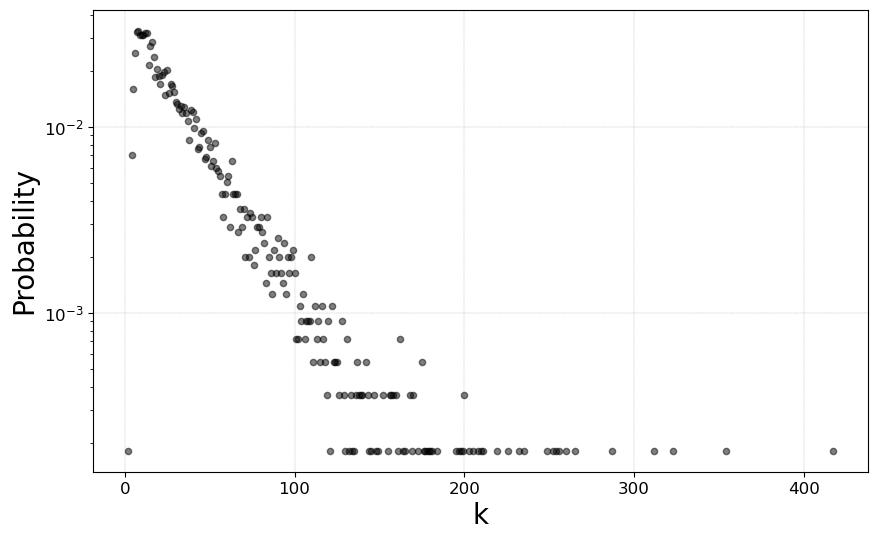

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, np.array(n_k)/n,linestyle='',marker = 'o', markersize=4.5,color=cmap2[9],alpha=0.5)
plt.xlabel('k', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(linestyle='--', linewidth=0.3)
plt.yscale('log')
# plt.xscale('log')
plt.show() 

#### Log-log Scale

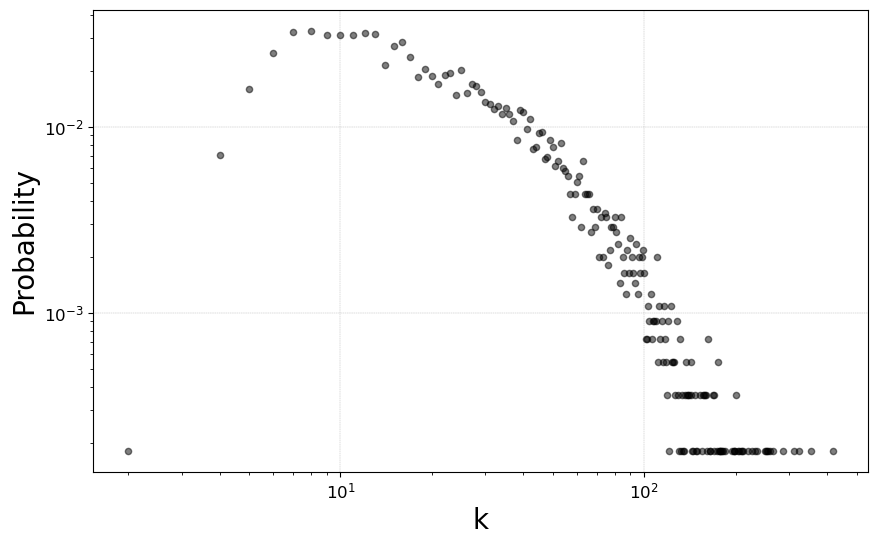

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, np.array(n_k)/n,linestyle='',marker = 'o', markersize=4.5,color=cmap2[9],alpha=0.5)
plt.xlabel('k', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(linestyle='--', linewidth=0.3)
plt.yscale('log')
plt.xscale('log')
plt.show() 

### CDF (L2)

In [35]:
def cdf_distribution(probabilities):
    cdf = []
    counter = 0
    for i in probabilities:
        counter += i 
        cdf.append(counter)
    return cdf

In [37]:
CDF_data = cdf_distribution(np.array(n_k)/n)

#### Normal CDF

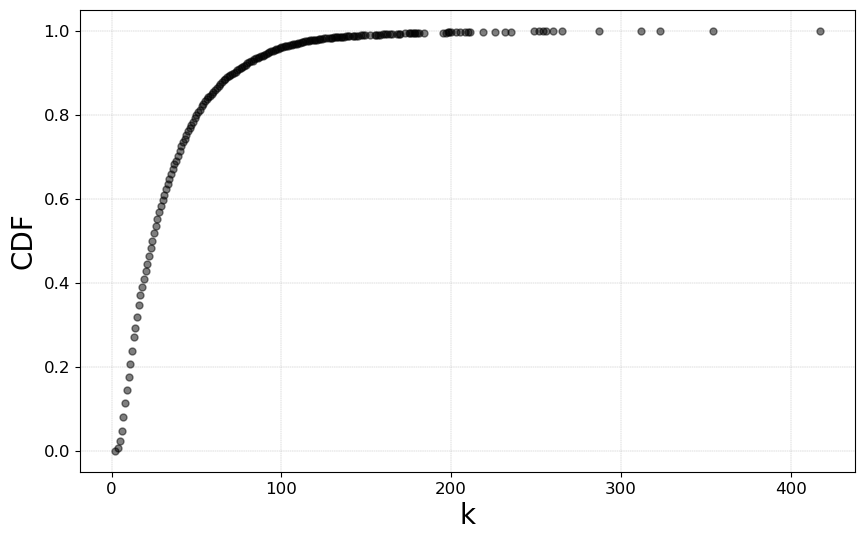

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, CDF_data,linestyle='',marker = 'o',markersize=5,color=cmap2[9],alpha=0.5)
plt.xlabel('k', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(linestyle='--', linewidth=0.3)
plt.show() 

#### CCDF 

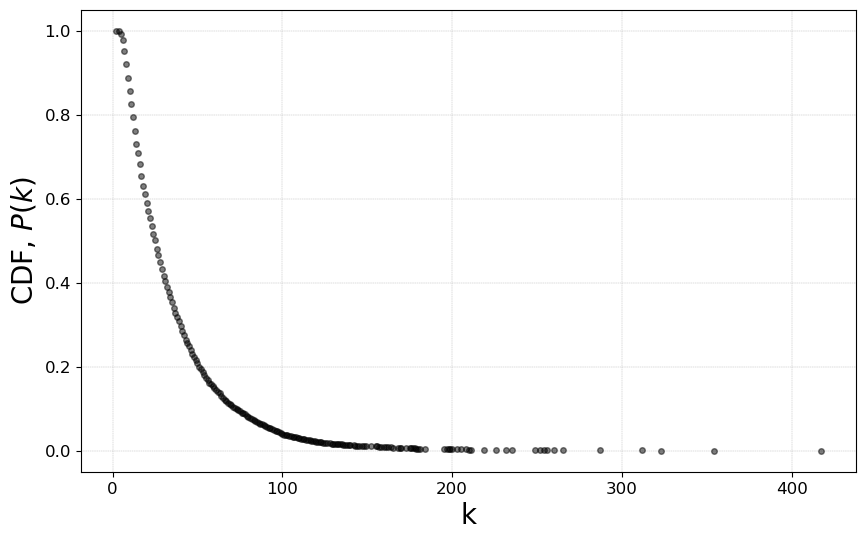

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(k_values,1 - np.concatenate([np.array([0]), CDF_data[:-1]]), linestyle='',label="L2 network",marker = 'o',markersize=4,color=cmap2[9],alpha=0.5)
plt.xlabel('k', fontsize=20)
plt.ylabel(r"CDF, $P(k)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(linestyle='--', linewidth=0.3)
plt.show() 

#### Semi-Log scale

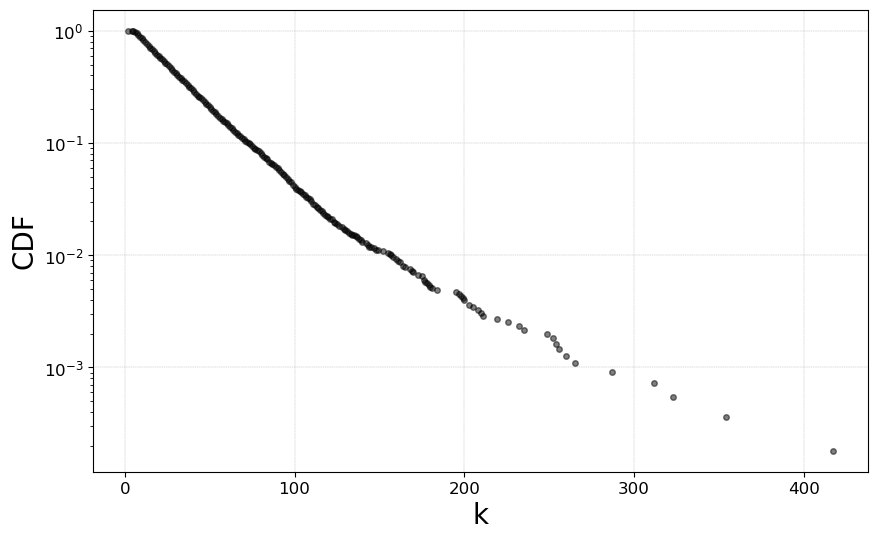

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(k_values,1 - np.concatenate([np.array([0]), CDF_data[:-1]]), linestyle='',label="L2 network",marker = 'o',markersize=4,color=cmap2[9],alpha=0.5)
plt.xlabel('k', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(linestyle='--', linewidth=0.3)
plt.yscale('log')
plt.show() 

#### Log-log scale

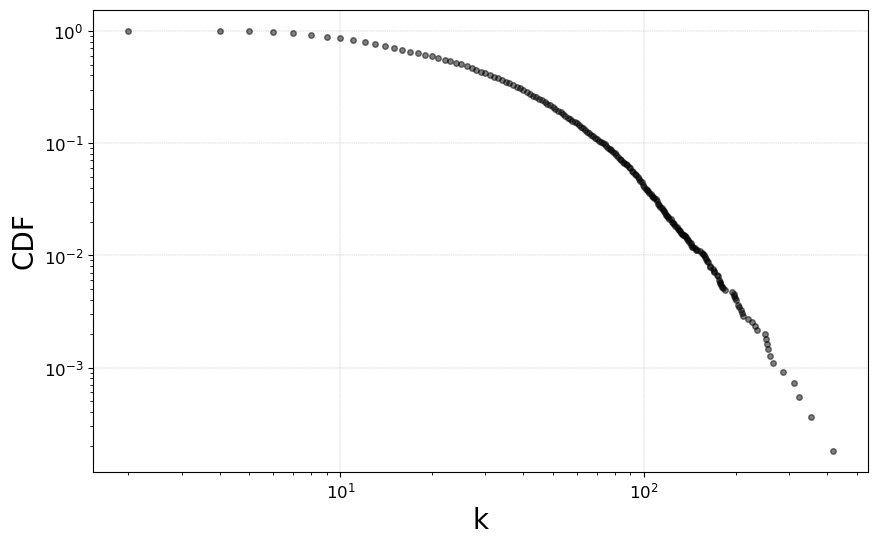

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(k_values,1 - np.concatenate([np.array([0]), CDF_data[:-1]]), linestyle='',label="L2 network",marker = 'o',markersize=4,color=cmap2[9],alpha=0.5)
plt.xlabel('k', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(linestyle='--', linewidth=0.3)
plt.yscale('log')
plt.xscale('log')
plt.show() 

### PDF - Fits

In [52]:
# Define the exponential function
def exponential(k,lambda_):
    return lambda_ * np.exp(-lambda_ * k)


def weibull_pdf(k, beta, alpha):
    return (beta / alpha) * (k / alpha) ** (beta - 1) * np.exp(-(k / alpha) ** beta)

def lognormal_pdf(k, sigma, mu):
    return (1 / (k * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(k) - mu) ** 2) / (2 * sigma ** 2))

def powerlaw_pdf(k, gamma):
    return (gamma-1)*k**(-gamma)
    
# Define the Exponentially Modified Gaussian (EMG) PDF
def emg_pdf(k, mu, sigma, lambda_):
    return (lambda_ / 2) * np.exp(lambda_ * (lambda_ * sigma**2 / 2 - (k - mu))) * \
           erfc((-k + mu + lambda_ * sigma**2) / (np.sqrt(2) * sigma))



In [54]:
n_k, k_values = degree_dist(G)
# Normalize frequencies to get probabilities
p_k = n_k / np.sum(n_k)
# Generate fitted values
k_fit = np.linspace(min(k_values), max(k_values),416)

##### Exponential

In [115]:
# Estimate lambda using Least Squares Fitting (LSF)
popt, pcov = curve_fit(exponential, k_values, p_k, p0=(0.1))
lambda_fit_exp = popt
print("lamda =",lambda_fit_exp)
exp_pdf_fit = exponential(k_fit, lambda_fit_exp)
pdf_exp_compare = exponential(np.array(k_values), lambda_fit_exp)
mse_pdf_exp = mean_squared_error(p_k, pdf_exp_compare)
print("MSE =",mse_pdf_exp)

ks_stat, p_value_ks = ks_2samp(p_k, pdf_exp_compare)

print(f"Kolmogorov-Smirnov Test: D = {ks_stat:.6f}, p-value = {p_value_ks:.6f}")

lamda = [0.03002543]
MSE = 2.959229897724597e-06
Kolmogorov-Smirnov Test: D = 0.344086, p-value = 0.000000


##### Weibull

In [62]:
# Fit the Weibull distribution using Least Squares Fitting (LSF)
popt, pcov = curve_fit(weibull_pdf, k_values, p_k)
beta_fit, alpha_fit = popt
print("beta =",beta_fit,"neta =",alpha_fit)
weibull_pdf_fit = weibull_pdf(k_fit, beta_fit, alpha_fit)

pdf_wei_compare = weibull_pdf(np.array(k_values), beta_fit, alpha_fit)
mse_weibull_pdf_fit = mean_squared_error(p_k,pdf_wei_compare )
print("MSE=",mse_weibull_pdf_fit)
ks_stat, p_value_ks = ks_2samp(p_k, pdf_wei_compare)
print(f"Kolmogorov-Smirnov Test: D = {ks_stat:.6f}, p-value = {p_value_ks:.8f}")

beta = 1.3730242143232856 neta = 29.206364646325994
MSE= 6.298860337946295e-06
Kolmogorov-Smirnov Test: D = 0.445026, p-value = 0.00000000


##### Log-Normal

In [65]:
popt, _ = curve_fit(lognormal_pdf, k_values, p_k, p0=(1.0, np.log(np.mean(k_values))))
sigma_fit, mu_fit = popt
lognormal_pdf_fit = lognormal_pdf(k_fit, sigma_fit, mu_fit)
print("sigma=",sigma_fit,'mu=',mu_fit)

pdf_Log_norm_compare = lognormal_pdf(np.array(k_values), sigma_fit, mu_fit)

mse_pdf_log_norm = mean_squared_error(p_k, pdf_Log_norm_compare)
print("MSE=",mse_pdf_log_norm)


ks_stat, p_value_ks = ks_2samp(p_k, pdf_Log_norm_compare)

print(f"Kolmogorov-Smirnov Test: D = {ks_stat:.6f}, p-value = {p_value_ks:.6f}")

sigma= 0.8776881400879337 mu= 3.137954689031688
MSE= 2.3813640553868454e-06
Kolmogorov-Smirnov Test: D = 0.172775, p-value = 0.006591


##### EMG

In [68]:
# Fit the EMG distribution using Least Squares Fitting (LSF)
popt, _ = curve_fit(emg_pdf, k_values, p_k)
mu_fit2, sigma_fit2, lambda_fit2 = popt
print("mu", mu_fit2, "sigma=",sigma_fit2,"lambda=",lambda_fit2)
EMG_fit = emg_pdf(k_fit, mu_fit2, sigma_fit2, lambda_fit2)

emg_pdf_compare = emg_pdf(np.array(k_values), mu_fit2, sigma_fit2,lambda_fit2)
mse_EMG_fit = mean_squared_error(p_k,emg_pdf_compare)
print("MSE=",mse_EMG_fit)

ks_stat, p_value_ks = ks_2samp(p_k, emg_pdf_compare)
print(f"Kolmogorov-Smirnov Test: D = {ks_stat:.6f}, p-value = {p_value_ks:.6f}")

mu 5.151076005563462 sigma= 1.3248701893117567 lambda= 0.03676286672190639
MSE= 1.0850954433416877e-06
Kolmogorov-Smirnov Test: D = 0.246073, p-value = 0.000017


##### Power-Law

In [71]:
# Fit the Power-Law using Least Squares Fitting (LSF)
popt, _ = curve_fit(powerlaw_pdf, k_values, p_k, maxfev=10000)
gamma_fit = popt
print("gamma =",gamma_fit)
power_law_pdf_fit = powerlaw_pdf(k_fit, gamma_fit)

pdf_PWL_compare = powerlaw_pdf(np.array(k_values), gamma_fit)
mse_pdf_pow = mean_squared_error(p_k,pdf_PWL_compare)
print("MSE =",mse_pdf_pow)

ks_stat, p_value_ks = ks_2samp(p_k, pdf_PWL_compare)

print(f"Kolmogorov-Smirnov Test: D = {ks_stat:.6f}, p-value = {p_value_ks:.6f}")

gamma = [1.09526064]
MSE = 6.570501068163617e-05
Kolmogorov-Smirnov Test: D = 0.293194, p-value = 0.000000


### PDF - Plots

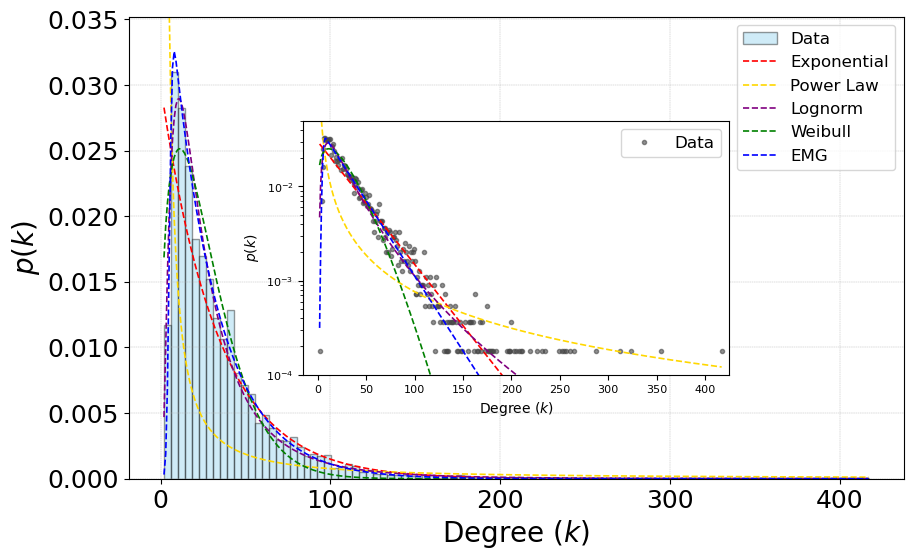

In [78]:
# Create the main figure
fig, ax_main = plt.subplots(figsize=(10, 6))
k_is = degrees(G)
# Histogram (Main Plot)
pdf, bins, _ = ax_main.hist(k_is, bins=101, density=True, color='skyblue', alpha=0.4, edgecolor='black', label="Data")

lw=1.2
# Plot different distributions
ax_main.plot(k_fit, exp_pdf_fit, color='red', linestyle='--', linewidth=lw,label=f'Exponential')
ax_main.plot(k_fit, power_law_pdf_fit, 'gold', linestyle='--',linewidth=lw, label=f'Power Law')
ax_main.plot(k_fit, lognormal_pdf_fit, 'purple', linestyle='--',linewidth=lw, label=f'Lognorm')
ax_main.plot(k_fit, weibull_pdf_fit, 'green', linestyle='--',linewidth=lw, label=f'Weibull')
ax_main.plot(k_fit, EMG_fit, color='blue', linestyle='--', linewidth=lw,label=f'EMG')

ax_main.grid(linestyle='--', linewidth=0.3)

# Labels and Legends
ax_main.set_xlabel(r"Degree $(k)$", fontsize=20)
ax_main.set_ylabel(r"$p(k)$", fontsize=20)
ax_main.tick_params(axis='both', which='major', labelsize=18)
ax_main.legend(fontsize=12)
ax_main.set_ylim(0,0.0352)

# Create the inset plot
ax_inset = inset_axes(ax_main, width="55%", height="55%", loc="center")  # Adjust size and position

# Inset Plot - Log-Log Scale
ax_inset.plot(k_values, p_k, linestyle='',marker = 'o',markersize=3,color=cmap2[7],alpha=0.6, label="Data")
ax_inset.plot(k_fit, exp_pdf_fit, color='red', linestyle='--', linewidth=lw)
ax_inset.plot(k_fit, power_law_pdf_fit, 'gold', linestyle='--',linewidth=lw)
ax_inset.plot(k_fit, lognormal_pdf_fit, 'purple', linestyle='--',linewidth=lw)
ax_inset.plot(k_fit, weibull_pdf_fit, 'green', linestyle='--',linewidth=lw)
ax_inset.plot(k_fit, EMG_fit, color='blue', linestyle='--',linewidth=lw)

# ax_inset.set_xscale('log')
ax_inset.set_yscale('log')
ax_inset.set_xlim(min(k_values), max(k_values))  # Adjust limits if needed
ax_inset.set_ylim(10**-4, 0.05)
ax_inset.set_xlim(-15,425)
# Inset Labels
ax_inset.set_xlabel(r"Degree $(k)$", fontsize=10)
ax_inset.set_ylabel(r"$p(k)$", fontsize=10)
ax_inset.tick_params(axis='both', which='major', labelsize=8)
ax_inset.legend(fontsize=12)

# plt.savefig("figures/pdf.png", dpi=300, bbox_inches='tight')  # High-resolution save
# Show plot
plt.show()


### CDF - Fits

In [3278]:
def cdf_distribution(probabilities):
    cdf = []
    counter = 0
    for i in probabilities:
        counter += i 
        cdf.append(counter)
    return cdf

In [3280]:
cdf_empirical = cdf_distribution(np.array(n_k)/n)

In [3282]:
def exponential_cdf(k, lambda_):
    return 1 - np.exp(-lambda_ * k)  # CDF formula for exponential

def lognormal_cdf(k, sigma, mu):
    return 0.5 * (1 + erf((np.log(k) - mu) / (sigma * np.sqrt(2))))

def weibull_cdf(k, beta, alpha):
    return 1 - np.exp(-(k / alpha) ** beta)

def emg_cdf(k, mu, sigma, lambda_):
    return 0.5 * (1 + erf((k - mu) / (np.sqrt(2) * sigma))) - np.exp(-lambda_ * (k - mu) + (lambda_**2 * sigma**2) / 2) * \
                  0.5 * (1 + erf((k - mu - lambda_ * sigma**2) / (np.sqrt(2) * sigma)))
    


In [3284]:
k_values = np.array(k_values)

In [3410]:
## Now consider the definition P(K)
cdf_fit = np.concatenate([np.array([0]), cdf_empirical[:-1]])
c_plot = 1 - cdf_fit

#### Exponential

In [3413]:
popt, _ = curve_fit(exponential_cdf, k_values, cdf_fit)
exp_lambda_cdf_fit = popt[0]
exp_cdf_fit = exponential_cdf(k_fit, exp_lambda_cdf_fit)
print("exp lamda:",exp_lambda_cdf_fit)

exp_compare_fit =  exponential_cdf(k_values, exp_lambda_cdf_fit)
mse_cdf = mean_squared_error(cdf_fit, exp_compare_fit)
print("MSE:",mse_cdf)

ks_stat, p_value_ks = ks_2samp(cdf_fit, exp_compare_fit)

print(f"Kolmogorov-Smirnov Test: D = {ks_stat:.6f}, p-value = {p_value_ks:.6f}")

exp lamda: 0.029243216653683665
MSE: 0.0009579050863351881
Kolmogorov-Smirnov Test: D = 0.057592, p-value = 0.910519


/var/folders/p2/wf0p252n7mjfjwt2py5yxhv80000gn/T/ipykernel_1007/1710757772.py:2: RuntimeWarning: overflow encountered in exp
  return 1 - np.exp(-lambda_ * k)  # CDF formula for exponential


#### Log-Normal

In [3418]:
# Fit the Log-Normal CDF using Least Squares Fitting (LSF)
popt, _ = curve_fit(lognormal_cdf, k_values, cdf_fit)
log_sigma_cdf_fit,log_mu_cdf_fit = popt
lognormal_cdf_fit = lognormal_cdf(k_fit, log_sigma_cdf_fit, log_mu_cdf_fit)
print("log sigma:",log_sigma_cdf_fit,"log mu",log_mu_cdf_fit)


lognormal_compare_fit =  lognormal_cdf( np.array(k_values), log_sigma_cdf_fit, log_mu_cdf_fit)
mse_cdf = mean_squared_error(cdf_fit, lognormal_compare_fit)
print("MSE:",mse_cdf)

ks_stat, p_value_ks = ks_2samp(cdf_fit, lognormal_compare_fit)

print(f"Kolmogorov-Smirnov Test: D = {ks_stat:.6f}, p-value = {p_value_ks:.6f}")

log sigma: 0.8395101256336759 log mu 3.212117548987698
MSE: 5.356704769472027e-05
Kolmogorov-Smirnov Test: D = 0.089005, p-value = 0.436698


#### EMG

In [3420]:
# Fit the EMG distribution using Least Squares Fitting (LSF) on CDF
popt, _ = curve_fit(emg_cdf, k_values, cdf_fit, p0=(5, 1, 0.04))
mu_cdf_fit, sigma_cdf_fit, lambda_cdf_fit = popt
emgcdf_fit = emg_cdf(k_fit, mu_cdf_fit, sigma_cdf_fit, lambda_cdf_fit)

print("EMG mu :",mu_cdf_fit,"EMG sigma",sigma_cdf_fit, "EMG lamda:", lambda_cdf_fit)

cdf_emg_compare_fit =  emg_cdf( np.array(k_values),mu_cdf_fit, sigma_cdf_fit, lambda_cdf_fit)
mse_cdf = mean_squared_error(cdf_fit, cdf_emg_compare_fit)
print("MSE:",mse_cdf)


ks_stat, p_value_ks = ks_2samp(cdf_fit, cdf_emg_compare_fit)

print(f"Kolmogorov-Smirnov Test: D = {ks_stat:.6f}, p-value = {p_value_ks:.5f}")

EMG mu : 5.168575113124469 EMG sigma 0.5636406778487056 EMG lamda: 0.03469815425314768
MSE: 1.873260282166236e-05
Kolmogorov-Smirnov Test: D = 0.094241, p-value = 0.36521


#### Weibull

In [3345]:
# Fit the Weibull CDF using Least Squares Fitting (LSF)
popt, _ = curve_fit(weibull_cdf, k_values, cdf_fit, p0=(1.5, np.mean(k_values)))
beta_cdf_fit, alpha_cdf_fit = popt
cdf_weibull_fit = weibull_cdf(k_fit, beta_cdf_fit, alpha_cdf_fit)
print("Wie beta=",beta_cdf_fit, "Wie alpha=",alpha_cdf_fit)

cdf_weibull_compare_fit =  weibull_cdf( np.array(k_values),beta_cdf_fit, alpha_cdf_fit)
mse_cdf = mean_squared_error(cdf_fit, cdf_weibull_compare_fit)
print("MSE:",mse_cdf)


ks_stat, p_value_ks = ks_2samp(cdf_fit, cdf_weibull_compare_fit)

print(f"Kolmogorov-Smirnov Test: D = {ks_stat:.6f}, p-value = {p_value_ks:.6f}")

Wie beta= 1.2209104419536416 Wie alpha= 35.206590404750486
MSE: 0.0003213964075074378
Kolmogorov-Smirnov Test: D = 0.178010, p-value = 0.004629


### CDF-Plots

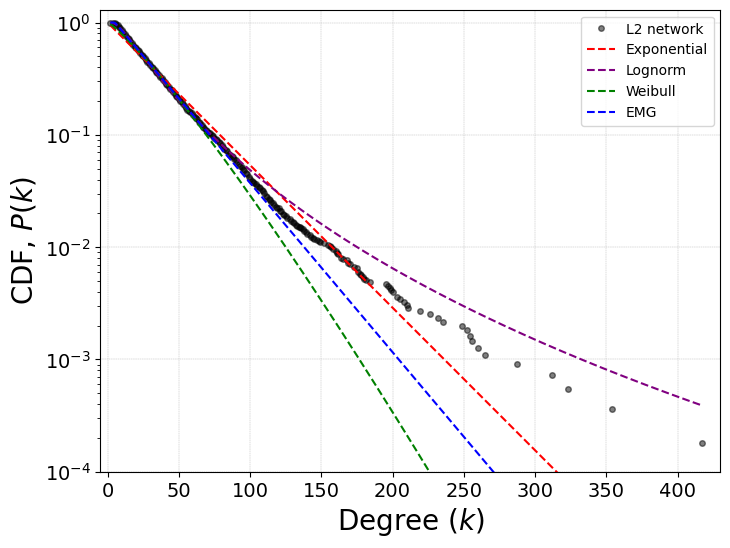

In [3425]:
plt.figure(figsize=(8,6))

plt.plot(k_values,1 - cdf_fit, linestyle='',label="L2 network",marker = 'o',markersize=4,color=cmap2[9],alpha=0.5)

# plt.plot(k_values,1 - np.array(cdf_empirical), linestyle='',label="L2 network",marker = 'o',markersize=4,color=cmap2[9],alpha=0.5)

plt.plot(k_fit, 1 - exp_cdf_fit, 'red', linestyle='--', label=f'Exponential')
# plt.plot(k_fit, 1 - cdf_powerlaw_fit, 'gold', linestyle='--', label=f'Power Law')
plt.plot(k_fit, 1 - lognormal_cdf_fit, 'purple', linestyle='--', label=f'Lognorm')
plt.plot(k_fit, 1 -cdf_weibull_fit, 'green', linestyle='--', label=f'Weibull')
plt.plot(k_fit, 1- emgcdf_fit, 'blue', linestyle='--', label=f'EMG')



plt.ylim(10**-4,1.3)
plt.xlabel(r"Degree $(k)$", fontsize=20)
plt.ylabel(r"CDF, $P(k)$", fontsize=20)
plt.legend()
plt.yscale('log')
# plt.xscale('log')

plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(linestyle='--', linewidth=0.3)

plt.xlim(-5,430)
# plt.savefig("figures/cdf_based_cdf.png", dpi=300, bbox_inches='tight')  # High-resolution save
plt.show()

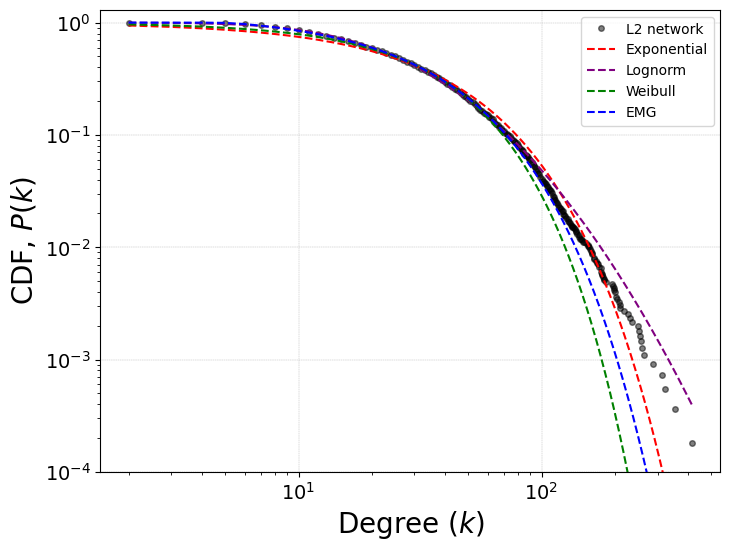

In [3427]:
plt.figure(figsize=(8,6))

plt.plot(k_values,1 - cdf_fit, linestyle='',label="L2 network",marker = 'o',markersize=4,color=cmap2[9],alpha=0.5)

# plt.plot(k_values,1 - np.array(cdf_empirical), linestyle='',label="L2 network",marker = 'o',markersize=4,color=cmap2[9],alpha=0.5)

plt.plot(k_fit, 1 - exp_cdf_fit, 'red', linestyle='--', label=f'Exponential')
# plt.plot(k_fit, 1 -cdf_powerlaw_fit, 'gold', linestyle='--', label=f'Power Law')
plt.plot(k_fit, 1 - lognormal_cdf_fit, 'purple', linestyle='--', label=f'Lognorm')
plt.plot(k_fit, 1 -cdf_weibull_fit, 'green', linestyle='--', label=f'Weibull')
plt.plot(k_fit, 1- emgcdf_fit, 'blue', linestyle='--', label=f'EMG')



plt.ylim(10**-4,1.3)
plt.xlabel(r"Degree $(k)$", fontsize=20)
plt.ylabel(r"CDF, $P(k)$", fontsize=20)
plt.legend()
plt.yscale('log')
plt.xscale('log')

plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(linestyle='--', linewidth=0.3)

# plt.xlim(-5,450)
# plt.savefig("figures/cdf_based_cdf.png", dpi=300, bbox_inches='tight')  # High-resolution save
plt.show()

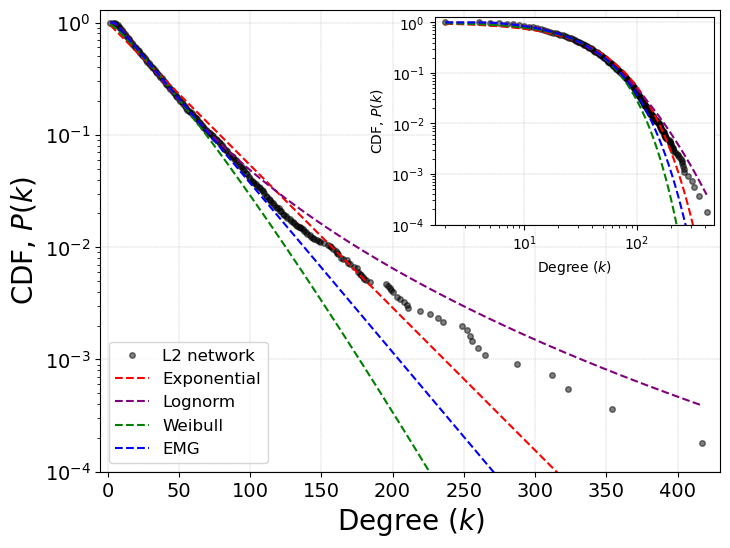

In [3429]:
# Create main figure
fig, ax_main = plt.subplots(figsize=(8, 6))

# Main plot
ax_main.plot(k_values, 1 - cdf_fit, linestyle='', label="L2 network", marker='o', markersize=4, color='black', alpha=0.5)
ax_main.plot(k_fit, 1 - exp_cdf_fit, 'red', linestyle='--', label='Exponential')
ax_main.plot(k_fit, 1 - lognormal_cdf_fit, 'purple', linestyle='--', label='Lognorm')
ax_main.plot(k_fit, 1 - cdf_weibull_fit, 'green', linestyle='--', label='Weibull')
ax_main.plot(k_fit, 1 - emgcdf_fit, 'blue', linestyle='--', label='EMG')

ax_main.set_ylim(10**-4, 1.3)
ax_main.set_xlabel(r"Degree $(k)$", fontsize=20)
ax_main.set_ylabel(r"CDF, $P(k)$", fontsize=20)
ax_main.set_yscale('log')
ax_main.grid(linestyle='--', linewidth=0.3)
ax_main.tick_params(axis='both', which='major', labelsize=14)
ax_main.set_xlim(-5, 430)
# ax_main.legend()

# Create inset plot (top-right)
ax_inset = inset_axes(ax_main, width="45%", height="45%", loc="upper right")


# Inset plot (log-log scale)
ax_inset.plot(k_values, 1 - cdf_fit, linestyle='', marker='o', markersize=4, color='black', alpha=0.5)
ax_inset.plot(k_fit, 1 - exp_cdf_fit, 'red', linestyle='--', label='Exponential')
ax_inset.plot(k_fit, 1 - lognormal_cdf_fit, 'purple', linestyle='--', label='Lognorm')
ax_inset.plot(k_fit, 1 - cdf_weibull_fit, 'green', linestyle='--', label='Weibull')
ax_inset.plot(k_fit, 1 - emgcdf_fit, 'blue', linestyle='--', label='EMG')

ax_inset.set_yscale('log')
ax_inset.set_xscale('log')
ax_inset.grid(linestyle='--', linewidth=0.3)
ax_inset.set_xlabel(r"Degree $(k)$", fontsize=10)
ax_inset.set_ylabel(r"CDF, $P(k)$", fontsize=10)
ax_inset.set_xlim(1.6, 480)  # Adjust x-axis limits if needed
ax_inset.set_ylim(10**-4,1.3)

ax_main.legend(fontsize=12,loc="lower left")

plt.savefig("figures/cdf_based_cdf.png", dpi=300, bbox_inches='tight')  # High-resolution save


plt.show()


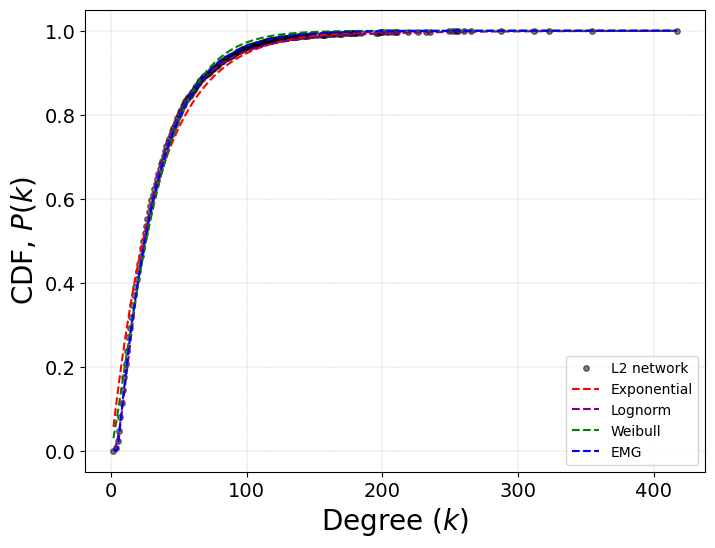

In [3355]:
plt.figure(figsize=(8,6))

# plt.plot(k_values,1 - np.concatenate([np.array([0]), cdf_empirical[:-1]]), linestyle='',label="L2 network",marker = 'o',markersize=4,color=cmap2[9],alpha=0.5)

plt.plot(k_values, np.array(cdf_empirical), linestyle='',label="L2 network",marker = 'o',markersize=4,color=cmap2[9],alpha=0.5)

plt.plot(k_fit,  exp_cdf_fit, 'red', linestyle='--', label=f'Exponential')
# plt.plot(k_fit, 1 -cdf_powerlaw_fit, 'gold', linestyle='--', label=f'Power Law')
plt.plot(k_fit,  lognormal_cdf_fit, 'purple', linestyle='--', label=f'Lognorm')
plt.plot(k_fit, cdf_weibull_fit, 'green', linestyle='--', label=f'Weibull')
plt.plot(k_values, cdf_emg_compare_fit, 'blue', linestyle='--', label=f'EMG')




plt.xlabel(r"Degree $(k)$", fontsize=20)
plt.ylabel(r"CDF, $P(k)$", fontsize=20)
plt.legend()
# plt.yscale('log')
# plt.xscale('log')

plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(linestyle='--', linewidth=0.3)

# plt.ylim(10**-4,1.3)
# plt.xlim(-5,430)
# plt.savefig("figures/cdf_based_cdf.png", dpi=300, bbox_inches='tight')  # High-resolution save
plt.show()

## f) Centrality Measures

In [2172]:
centralities = {}

### Degree

In [250]:
centralities["degree"] = nx.degree_centrality(G)

### Closeness

In [252]:
centralities["closeness"] = nx.closeness_centrality(G)

### Betweenness

In [253]:
centralities["betweenness"] = nx.betweenness_centrality(G)

### Eigenvector

In [2174]:
centralities["eigenvector"] = nx.eigenvector_centrality(G)

### Katz

In [51]:
largest_eigenvalue = max(np.linalg.eigvals(nx.adjacency_matrix(G).toarray()))
alpha = 1 / (largest_eigenvalue + 1e-5) 

In [307]:
alpha

0.01278787305165347

In [69]:
centralities["katz"] = nx.katz_centrality(G, alpha=0.012, beta=1.0)

In [43]:
centralities.keys()

dict_keys(['degree', 'closeness', 'betweenness', 'eigenvector', 'PageRank', 'Subgraph', 'katz'])

### PageRank

In [260]:
centralities["PageRank"] = nx.pagerank(G)

### Subgraph

In [2176]:
centralities["Subgraph"] = nx.subgraph_centrality(G)

### All Results

In [2162]:
centralities.keys()

dict_keys(['degree', 'closeness', 'betweenness', 'eigenvector', 'PageRank', 'Subgraph', 'katz'])

### Save Results 

In [109]:
# filename = "results/7_centralities.pkl"
# with open(filename, "wb") as file:
#     pickle.dump(centralities, file)


In [1413]:
filename = "results/7_centralities.pkl"

# Abrir el archivo en modo lectura binaria
with open(filename, "rb") as file:
    centralities = pickle.load(file)



### Rankings

In [132]:
metric_leaders = {}

df_centralities = pd.DataFrame(centralities)
for metric in df_centralities.columns:
    top_nodes = df_centralities[metric].nlargest(25).reset_index()
    top_nodes.columns = ["Node", metric]
    metric_leaders[metric] = top_nodes

final_table = pd.DataFrame({"Ranking": range(1, 26)})

for metric, table in metric_leaders.items():
    final_table[f"Node {metric}"] = table["Node"]

# #Save
final_table.to_csv("top_25_centralities_combined.csv", index=False)
# final_table.to_latex("top_25_centralities_combined.tex", index=False, longtable=True)

print(final_table)


    Ranking  Node degree  Node closeness  Node betweenness  Node eigenvector  \
0         1          260             260               231               260   
1         2           76             586               549               571   
2         3          312             524               951               312   
3         4          571             571               260               524   
4         5          524             249              1760               249   
5         6          586             202               852              1522   
6         7          249             563                64               315   
7         8         1540             247               586              1540   
8         9          372             231                76               481   
9        10          315             169               202              1763   
10       11          951             262               563               372   
11       12           64             312

In [141]:

df_centralities = pd.DataFrame(centralities)

top_25 = {}
for metric in df_centralities.columns:
    top_nodes = df_centralities[metric].nlargest(25).reset_index()
    top_nodes.columns = ["Node", metric]
    top_25[metric] = top_nodes

final_table = pd.concat(top_25.values(), axis=1)

final_table = final_table.loc[:, ~final_table.columns.duplicated()]

final_table.insert(0, "Ranking", range(1, 26))


print(final_table)

# final_table.to_csv("top_25_centralities.csv", index=False)




    Ranking  Node    degree  closeness  betweenness  eigenvector  PageRank  \
0         1   260  0.075502   0.428173     0.072839     0.152705  0.001991   
1         2    76  0.064096   0.413213     0.067947     0.135888  0.001673   
2         3   312  0.058483   0.406342     0.040909     0.118531  0.001334   
3         4   571  0.056491   0.403433     0.038704     0.115040  0.001296   
4         5   524  0.051965   0.401322     0.036917     0.109785  0.001294   
5         6   586  0.047981   0.400246     0.034995     0.100197  0.001240   
6         7   249  0.047076   0.396056     0.034957     0.099393  0.001232   
7         8  1540  0.046352   0.395291     0.030977     0.097787  0.001191   
8         9   372  0.045989   0.394754     0.024104     0.096810  0.001145   
9        10   315  0.045627   0.394106     0.022213     0.094112  0.001123   
10       11   951  0.045084   0.393741     0.019217     0.093944  0.001094   
11       12    64  0.042549   0.393124     0.018835     0.093019

## g) Degree assortativity

In [132]:
D_A = nx.degree_assortativity_coefficient(G)

In [134]:
print(f"The assortativity of the network is: {D_A}")


The assortativity of the network is: 0.10386015130947386


## h) Bipartite

In [107]:
# General Network Properties Functions
def bipartivity(G):
    
    A = nx.adjacency_matrix(G).toarray()

    # Calculate the matrix exponential for A and -A
    exp_A = expm(A); exp_neg_A = expm(-A)

    # Calculate the traces of both exp_A and exp_neg_A
    trace_exp_A = np.trace(exp_A)
    trace_exp_neg_A = np.trace(exp_neg_A)

    return trace_exp_neg_A / trace_exp_A

In [109]:
b_i = bipartivity(G)

In [111]:
print(f"The bipartivity index is: {b_i}")



The bipartivity index is: 1.2030704144428219e-25


In [119]:
def bipartivity(G):
    A = nx.to_numpy_array(G)
    eigvals, eigvect = np.linalg.eigh(A)
    return sum(np.cosh(v) - np.sinh(v) for v in eigvals)/sum(np.exp(v) for v in eigvals)

In [115]:
b_i = bipartivity(G)
print(f"The bipartivity index is: {b_i}")

The bipartivity index is: 1.2030704144428455e-25


# Part 2

### Metrics

In [681]:
def calculate_metrics(G):
    metrics = {
        "Average Clustering": nx.average_clustering(G),
        "Transitivity index": nx.transitivity(G),
        "Average Shortest Path Length": nx.average_shortest_path_length(G),
        "Diameter": nx.diameter(G),
        "Degree Assortativity": nx.degree_assortativity_coefficient(G),
        "Bipartivity Index": bipartivity(G),
    }
    return metrics

In [683]:
metrics_iterations = {
    "ER": {},
    "BA": {}
}
metrics_summary = {}

## Erdos Renyi Networks

### Calculate parameter p Erdos Renyi

In [740]:
p = 2 * m / (n * (n - 1))
G_ER = nx.erdos_renyi_graph(n, p)
len(G_ER.edges)

94093

In [691]:
for i in range(0,10):
    G_ER = nx.erdos_renyi_graph(n, p)
    metrics_iterations["ER"][i] = calculate_metrics(G_ER)

## Albert Barabasi Networks

### Calculate parameter m Albert Barabasi

In [1004]:
m_av = int(m/n)
G_AB = nx.barabasi_albert_graph(n, m_av)
len(G_AB.edges)

93619

In [146]:
for i in range(0,10):
    G_AB = nx.barabasi_albert_graph(n, m_av)
    metrics_iterations["BA"][i] = calculate_metrics(G_AB)

## Average and standard deviation values

### Metrics Average

In [ ]:
ba_metrics_df = pd.DataFrame(metrics_iterations["BA"]).T
ba_means = ba_metrics_df.mean()
ba_stds = ba_metrics_df.std()
metrics_summary = {
    "BA": {
        metric: {"mean value": ba_means[metric], "standard deviation": ba_stds[metric]}
        for metric in ba_means.index
    }
}

In [695]:
er_metrics_df = pd.DataFrame(metrics_iterations["ER"]).T
er_means = er_metrics_df.mean()
er_stds = er_metrics_df.std()

metrics_summary["ER"] = {
        metric: {"mean value": er_means[metric], "standard deviation": er_stds[metric]}
        for metric in er_means.index
    }

In [1028]:
metrics_summary

{'BA': {'Average Clustering': {'mean value': 0.024871367298999546,
   'standard deviation': 0.0006829332675737707},
  'Transitivity index': {'mean value': 0.023371788215865358,
   'standard deviation': 0.00017145852330330857},
  'Average Shortest Path Length': {'mean value': 2.706189481075977,
   'standard deviation': 0.0028923887720340873},
  'Diameter': {'mean value': 4.0, 'standard deviation': 0.0},
  'Degree Assortativity': {'mean value': -0.011586094954815083,
   'standard deviation': 0.0032627130996340137},
  'Bipartivity Index': {'mean value': 3.169690118025896e-20,
   'standard deviation': 8.649236140664447e-21},
  'Transitivity Index': {'mean value': 0.023286692205482698,
   'standard deviation': 0.00035051271679661526}},
 'ER': {'Average Clustering': {'mean value': 0.006128283710639393,
   'standard deviation': 0.00010604233541459519},
  'Transitivity index': {'mean value': 0.006137538158214353,
   'standard deviation': 0.00011880690337143542},
  'Average Shortest Path Length

### Save

In [587]:
# output_file_path = "results/metrics_summary.json"
# with open(output_file_path, "w") as file:
#     json.dump(metrics_summary, file, indent=4)



### Upload

In [133]:
output_file_path = "results/metrics_summary.json"

# Open and read the JSON file
with open(output_file_path, "r") as file:
    metrics_summary = json.load(file)

# Print the content of the file
print(json.dumps(metrics_summary, indent=4))

{
    "BA": {
        "Average Clustering": {
            "mean value": 0.024871367298999546,
            "standard deviation": 0.0006829332675737707
        },
        "Transitivity index": {
            "mean value": 0.023371788215865358,
            "standard deviation": 0.00017145852330330857
        },
        "Average Shortest Path Length": {
            "mean value": 2.706189481075977,
            "standard deviation": 0.0028923887720340873
        },
        "Diameter": {
            "mean value": 4.0,
            "standard deviation": 0.0
        },
        "Degree Assortativity": {
            "mean value": -0.011586094954815083,
            "standard deviation": 0.0032627130996340137
        },
        "Bipartivity Index": {
            "mean value": 3.169690118025896e-20,
            "standard deviation": 8.649236140664447e-21
        }
    },
    "ER": {
        "Average Clustering": {
            "mean value": 0.006128283710639393,
            "standard deviation": 0.0001

### PDF and CDF

#### Functions 

In [1013]:
def generate_random_networks(graph, model='ER', N_networks=10):
    n = graph.number_of_nodes()
    m = graph.number_of_edges()
    random_graphs = []

    for _ in range(N_networks):
        if model == 'ER':
            p = 2 * m / (n * (n - 1))  # Probability for ER model
            random_graphs.append(nx.erdos_renyi_graph(n, p))
        elif model == 'BA':
            m_ba = m // n  # Edges per node for BA model
            random_graphs.append(nx.barabasi_albert_graph(n, m_ba))
            
    return random_graphs


In [1015]:
er_graphs = generate_random_networks(G, model='ER', N_networks=10)
ba_graphs = generate_random_networks(G, model='BA', N_networks=10)

In [1037]:
def get_common_k_values(graphs):
    """Find the union of all unique degree values across multiple networks."""
    all_k_values = set()
    for graph in graphs:
        degrees = [d for _, d in graph.degree()]
        all_k_values.update(degrees)  # Collect all observed degree values
    return np.sort(list(all_k_values))  # Return sorted array of unique k-values

# Find common k-values for ER and BA networks
er_k_values = get_common_k_values(er_graphs)
ba_k_values = get_common_k_values(ba_graphs)

def calculate_pdf_cdf(graph, k_values_standard):
    """Compute PDF and CDF, ensuring alignment with predefined k-values."""
    degrees = np.array([d for _, d in graph.degree()])
    k_values, counts = np.unique(degrees, return_counts=True)
    
    # Initialize PDFs with zeros and fill known degree values
    pdf = np.zeros_like(k_values_standard, dtype=float)
    cdf = np.zeros_like(k_values_standard, dtype=float)
    
    for i, k in enumerate(k_values_standard):
        if k in k_values:
            pdf[i] = counts[k_values == k].sum() / counts.sum()  # Normalize
    cdf = np.cumsum(pdf)  # Compute cumulative distribution function

    return pdf, cdf


# Compute PDF & CDF for ER Networks
er_pdfs, er_cdfs = [], []
for graph in er_graphs:
    pdf, cdf = calculate_pdf_cdf(graph, er_k_values)
    er_pdfs.append(pdf)
    er_cdfs.append(cdf)

# Compute PDF & CDF for BA Networks
ba_pdfs, ba_cdfs = [], []
for graph in ba_graphs:
    pdf, cdf = calculate_pdf_cdf(graph, ba_k_values)
    ba_pdfs.append(pdf)
    ba_cdfs.append(cdf)

def get_average_distribution(dist_list):
    """Compute average and standard deviation of aligned distributions."""
    dist_array = np.array(dist_list)  # Convert list to NumPy array
    avg_dist = np.mean(dist_array, axis=0)
    std_dist = np.std(dist_array, axis=0)
    return avg_dist, std_dist

# ER Model
er_avg_pdf, er_std_pdf = get_average_distribution(er_pdfs)
er_avg_cdf, er_std_cdf = get_average_distribution(er_cdfs)

# BA Model
ba_avg_pdf, ba_std_pdf = get_average_distribution(ba_pdfs)
ba_avg_cdf, ba_std_cdf = get_average_distribution(ba_cdfs)


In [256]:
with open("degree_distribution_metrics.pkl", "rb") as f:
    results = pickle.load(f)

### Erdos

In [3041]:
er_k_values[0], er_k_values[-1] 

(12, 59)

In [3037]:
max(er_avg_pdf)

0.07060101375814626

In [2153]:
er_k_values[21], er_avg_pdf[21]

(34, 0.07060101375814626)

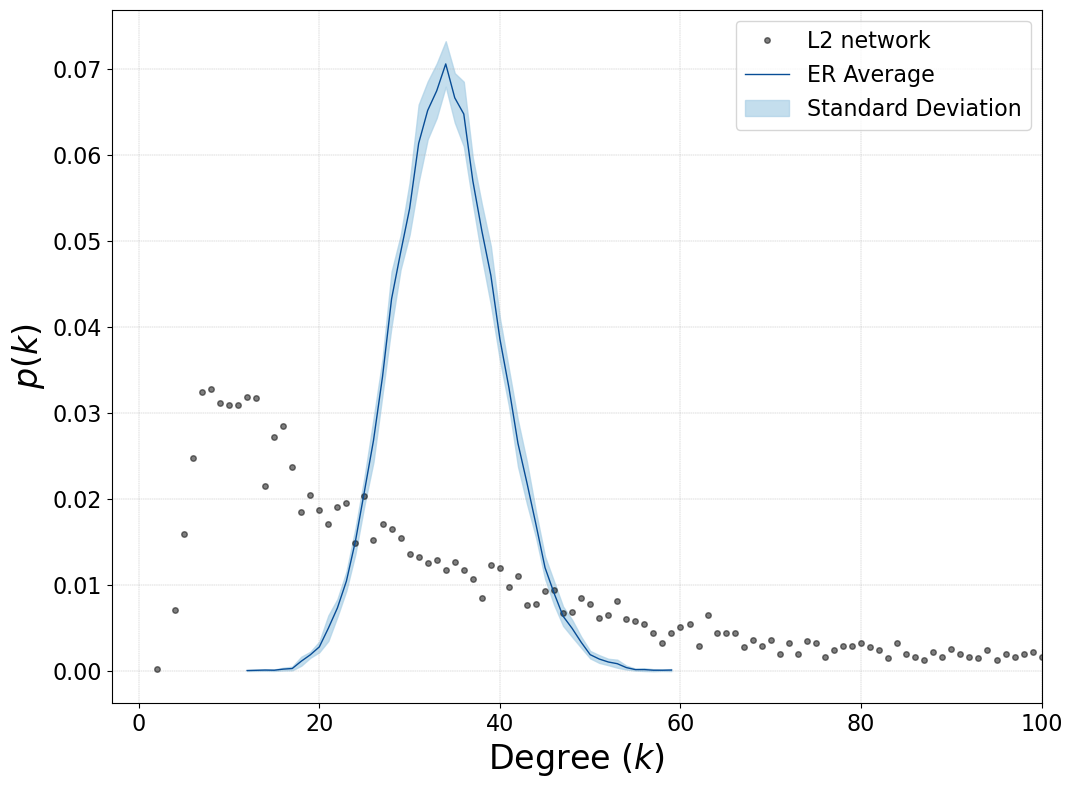

In [1312]:
plt.figure(figsize=(12, 9))
plt.plot(k_values_real, pdf_real, linestyle='',label="L2 network",marker = 'o',markersize=4,color=cmap2[9],alpha=0.5)
# plt.plot(k_values, pdf_real, linestyle='--', marker='o', markersize=1.5, color='k', label="Real Network PDF")

plt.plot(er_k_values, er_avg_pdf,linewidth=1., label="ER Average", color=cmap[8])
# plt.plot(k_s_erdos,avg_erdos,linewidth=1., label="ER Avgerage", color=cmap[8])
plt.fill_between(er_k_values, er_avg_pdf - er_std_pdf, er_avg_pdf + er_std_pdf, alpha=0.7, color=cmap[3], label="Standard Deviation")
plt.xlabel(r"Degree $(k)$", fontsize=24)
plt.ylabel(r"$p(k)$", fontsize=24)
plt.legend(fontsize=16)
plt.grid(linestyle='--', linewidth=0.3)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlim(-3,100)
# plt.title(f"PDF Comparison: Real vs ER Model", fontsize=16)
plt.savefig('figures/pdf_ER.png', dpi=300, bbox_inches='tight')
plt.show()


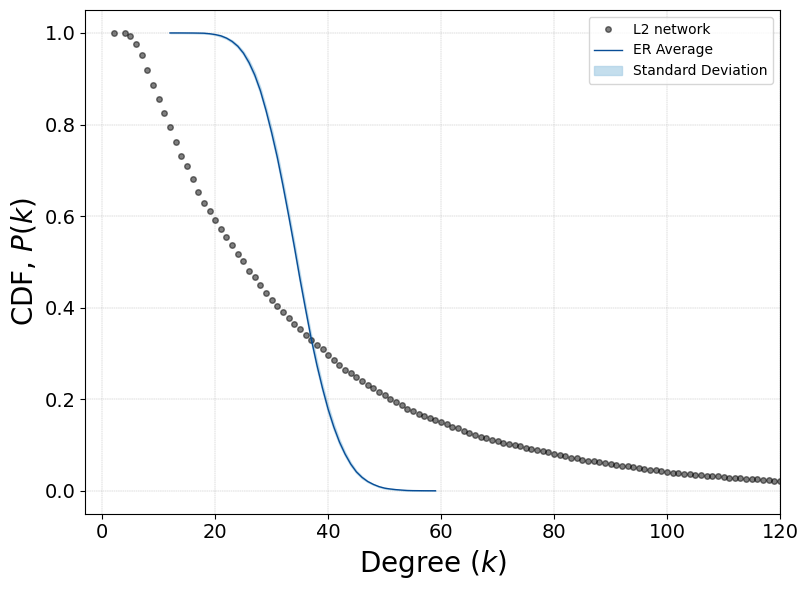

In [1310]:
plt.figure(figsize=(8, 6))
er_cdf = np.concatenate([np.array([0]), er_avg_cdf[:-1]])
plt.plot(k_values_real, 1- np.concatenate([np.array([0]), cdf_real[:-1]]), linestyle='',label="L2 network",marker = 'o',markersize=4,color=cmap2[9],alpha=0.5)

plt.plot(er_k_values, 1 -er_cdf , linewidth=1., label="ER Average", color=cmap[8])
plt.fill_between(er_k_values, 1 - (er_cdf - er_std_cdf), 1- (er_cdf + er_std_cdf),  alpha=0.7, color=cmap[3], label="Standard Deviation")

plt.xlabel(r"Degree $(k)$", fontsize=20)
plt.ylabel(r"CDF, $P(k)$", fontsize=20)
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

plt.grid(linestyle='--', linewidth=0.3)

plt.xlim(-3,120)
# plt.xscale('log')
# plt.title(f"CDF Comparison: Data vs ER Model", fontsize=16)
plt.savefig('figures/cdf_ER.png', dpi=300, bbox_inches='tight')
plt.show()

### Barabasi

In [3046]:
ba_k_values[0], ba_k_values[-1]

(17, 554)

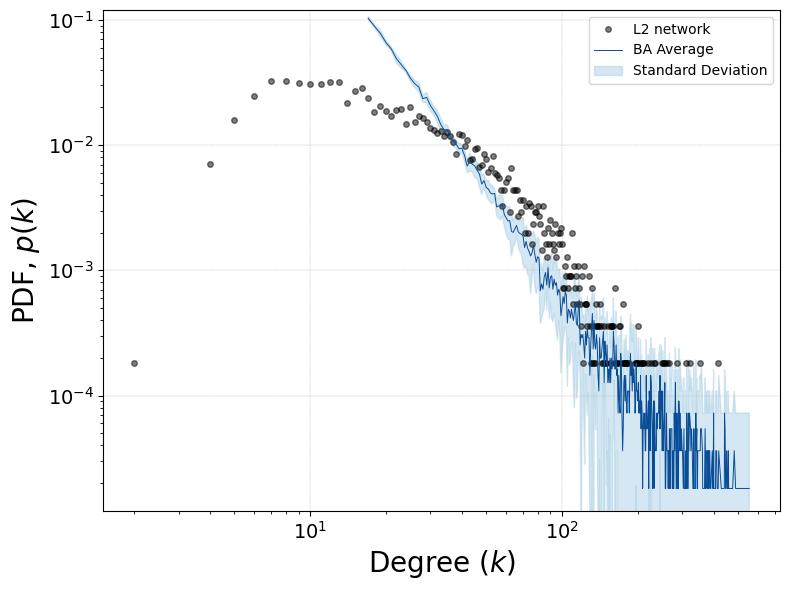

In [1314]:
plt.figure(figsize=(8, 6))

plt.plot(k_values_real, pdf_real, linestyle='',label="L2 network",marker = 'o',markersize=4,color=cmap2[9],alpha=0.5)

plt.plot(ba_k_values, ba_avg_pdf, linewidth=.7, label="BA Average", color=cmap[8])
plt.fill_between(ba_k_values, ba_avg_pdf - ba_std_pdf, ba_avg_pdf + ba_std_pdf, alpha=0.5, color=cmap[3], label="Standard Deviation")

plt.grid(linestyle='--', linewidth=0.3)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r"Degree $(k)$", fontsize=20)
plt.ylabel(r"PDF, $p(k)$", fontsize=20)
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

plt.ylim(1.2*10**-5,1.2*10**-1)

# plt.title(f"PDF Comparison: Data vs AB Model", fontsize=16)
plt.savefig('figures/pdf_BA.png', dpi=300, bbox_inches='tight')
plt.show()


In [1235]:
ba_new_cdf = np.concatenate([np.array([0]), ba_avg_cdf[:-1]])
ba_std = np.concatenate([np.array([0]), ba_std_cdf[:-1]])

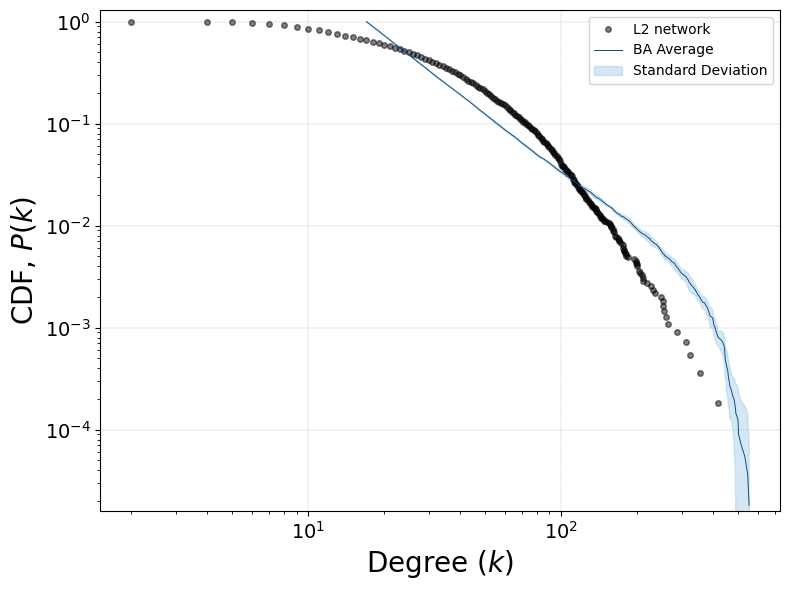

In [1315]:
plt.figure(figsize=(8, 6))

plt.plot(k_values_real, 1 - np.concatenate([np.array([0]), cdf_real[:-1]]), linestyle='',label="L2 network",marker = 'o',markersize=4,color=cmap2[9],alpha=0.5)

plt.plot(ba_k_values, 1 - ba_new_cdf, linewidth=.7, label="BA Average", color=cmap[8])
plt.fill_between(ba_k_values, 1  - (ba_new_cdf - ba_std), 1 - (ba_new_cdf + ba_std), alpha=0.5, color=cmap[3], label="Standard Deviation")

plt.xscale('log')
plt.yscale('log')


plt.xlabel(r"Degree $(k)$", fontsize=20)
plt.ylabel(r"CDF, $P(k)$", fontsize=20)
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

plt.grid(linestyle='--', linewidth=0.3)

plt.ylim(1.6*10**-5,1.3)
# plt.title(f"PDF Comparison: Data vs AB Model", fontsize=16)
plt.savefig('figures/cdf_BA.png', dpi=300, bbox_inches='tight')
plt.show()


## Part III: find communities and modularity

### Greedy

In [ ]:
def compute_performance(G, communities):
    total_pairs = G.number_of_nodes() * (G.number_of_nodes() - 1) / 2
    intra_edges = sum(G.subgraph(comm).number_of_edges() for comm in communities)
    non_edges = sum(len(comm) * (len(comm) - 1) / 2 for comm in communities) - intra_edges
    return (intra_edges + non_edges) / total_pairs

In [ ]:
communities = list(community.greedy_modularity_communities(G))
modularity = community.modularity(G, communities)
print(f"Number of communities detected: {len(communities)}")
print(f"Modularity: {modularity:.4f}")


In [ ]:
for i, community_group in enumerate(communities, start=1):
    # print(f"Community {i}: {sorted(community_group)}")
results = {
    "Number of communities": len(communities),
    "Modularity": modularity,
    "Communities": {f"Community {i+1}": list(map(int, community)) for i, community in enumerate(communities)}
}

# # Be careful Save
# with open("results/community_detection_results.json", "w") as f:
#     json.dump(results, f, indent=4)


In [1393]:
with open("results/community_detection_results.json", "r") as f:
    loaded_results = json.load(f)

In [1395]:
loaded_results.keys()

dict_keys(['Number of communities', 'Modularity', 'Communities'])

In [1391]:
communities_greedy = loaded_results['Communities']

In [240]:
performance_greedy = compute_performance(G, Communities.values())

coverage_greedy, performance_greedy = nx_comm.partition_quality(G, communities_greedy.values())

print(f"Performance (Greedy): {performance_greedy:.4f}")
print(f"Coverage (Greedy): {coverage_greedy:.4f}")

Performance (Greedy): 0.6697
Coverage (Greedy): 0.8764


In [ ]:
communities = list(community.greedy_modularity_communities(G))
modularity = community.modularity(G, communities)
print(f"Number of communities detected: {len(communities)}")
print(f"Modularity: {modularity:.4f}")


### Louvain Algorithm

In [ ]:
def compute_performance(G, communities):
    total_pairs = G.number_of_nodes() * (G.number_of_nodes() - 1) / 2
    intra_edges = sum(G.subgraph(comm).number_of_edges() for comm in communities)
    non_edges = sum(len(comm) * (len(comm) - 1) / 2 for comm in communities) - intra_edges
    return (intra_edges + non_edges) / total_pairs

In [106]:
partition_louvain = community_louvain.best_partition(G)
communities_louvain = {}
for node, comm_id in partition_louvain.items():
    if comm_id not in communities_louvain:
        communities_louvain[comm_id] = []
    communities_louvain[comm_id].append(node)
modularity_louvain = community.modularity(G, communities_louvain.values())
print("\nLouvain Method:")
print(f"Number of communities detected: {len(communities_louvain)}")
print(f"Modularity: {modularity_louvain:.4f}")



Louvain Method:
Number of communities detected: 11
Modularity: 0.6065


In [238]:
performance_louvain = compute_performance(G, communities_louvain.values())

coverage_louvain, performance_louvain = nx_comm.partition_quality(G, communities_louvain.values())

print(f"Performance (Louvain): {performance_louvain:.4f}")
print(f"Coverage (Louvain): {coverage_louvain:.4f}")

Performance (Louvain): 0.8800
Coverage (Louvain): 0.7266


## Part IV Visualize the network 

### Positions

In [3058]:
positions = [data['pos'] for node, data in G.nodes(data=True) if 'pos' in data]
pos = np.array(positions) 

### Sizes

In [3073]:
node_sizes = [400 * centralities["degree"][node] for node in G.nodes()]

### Shape

In [3117]:
# Load the top 25 centralities data
centralities_file = "top_25_centralities_combined.csv"  # Replace with the correct file path if needed
top_25_centralities = pd.read_csv(centralities_file)
top_25_centralities
# Extract the list of unique nodes ranked in the top 25 for any centrality metric
top_25_nodes = set()
for column in top_25_centralities.columns:
    if column.startswith("Node"):
        top_25_nodes.update(top_25_centralities[column].unique())



In [3119]:
top_51_nodes = set([
    260, 312, 571, 524, 249, 586, 372, 315, 1540, 76, 951, 481, 64, 1522, 
    852, 202, 570, 1102, 1763, 860, 142, 231, 822, 509, 563, 356, 247, 1262, 
    508, 169, 1568, 549, 2507, 1760, 262, 2149, 1971, 399, 1986, 439, 1705, 
    311, 1139, 282, 793, 1736, 1077, 855, 2510, 257, 1987
])


# Create a mapping to distinguish these nodes
node_shapes = {node: 's' if node in top_50_nodes else 'o' for node in G.nodes()}  # Squares for top nodes, circles otherwise

node_edge_colors = {node: cmap2[7] if node in top_50_nodes else node_colors[node] for node in G.nodes()}

node_linewidths = {node: 0.5 if node in top_50_nodes else 1.0 for node in G.nodes()}

### Edges

#### Diameter path

In [3128]:
# Compute the diameter of the network (longest shortest path)
diameter_nodes = nx.diameter(G)
shortest_paths = nx.all_pairs_shortest_path(G)

# Find the pair of nodes with the longest shortest path (diameter nodes)
diameter_path = []
max_length = 0

for source, paths in shortest_paths:
    for target, path in paths.items():
        if len(path) > max_length:
            max_length = len(path)
            diameter_path = path



In [3130]:
diameter_path

[2590, 2578, 2580, 825, 855, 3277, 4681, 1515, 1127, 2653]

### Colors

#### Louvain

In [3159]:
unique_communities = list(set(partition_louvain.values()))
color_map = {comm_id: plt.colormaps.get_cmap("tab20")(i % 11) for i, comm_id in enumerate(unique_communities)}
node_colors = [color_map[partition_louvain[node]] for node in G.nodes()]


In [3161]:
# Position nodes based on communities
def get_community_layout(G, partition,pos1):
    """Position nodes so that communities are grouped together."""
      # Initial layout
    community_positions = {}
    
    for comm_id, nodes in partition.items():
        center_x, center_y = np.mean([pos[n] for n in nodes], axis=0)  # Community center
        for n in nodes:
            pos1[n] = pos1[n] + (0.8*(center_x + np.random.uniform(-0.005, 0.005)), 0.7*(center_y + np.random.uniform(-0.01, 0.01)))
    
    return pos1
pos1 = pos.copy()
pos2 = get_community_layout(G, communities_louvain,pos1)

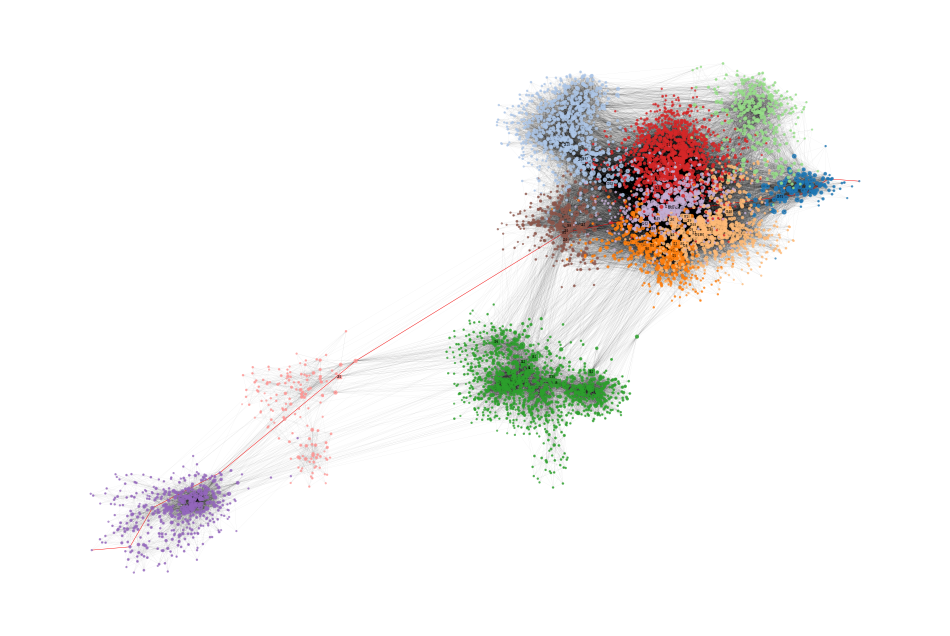

In [3165]:
# Drawing
plt.figure(figsize=(12, 8))
# pos = nx.spring_layout(G, seed=42)
# nx.draw_networkx_nodes(G, pos1, node_color=node_colors, node_size=node_sizes, alpha=0.8)

# Draw nodes with different shapes
for shape in set(node_shapes.values()):  
    nodes_to_draw = [node for node in G.nodes() if node_shapes[node] == shape]
    nx.draw_networkx_nodes(
        G, pos1, nodelist=nodes_to_draw, 
        node_color=[node_colors[i] for i in nodes_to_draw],  # Keep original colors
        node_size=[node_sizes[i] for i in nodes_to_draw],  # Keep original sizes
        alpha=0.75,
        node_shape=shape  # Apply different shapes
    )
labels = {node: str(node) for node in top_50_nodes if node in G.nodes}
nx.draw_networkx_labels(G, pos1, labels=labels, font_size=2, font_color='black')

nx.draw_networkx_edges(G, pos1, alpha=0.4, width=0.025)
edges_in_diameter = [(diameter_path[i], diameter_path[i+1]) for i in range(len(diameter_path)-1)]
nx.draw_networkx_edges(G, pos1, edgelist=edges_in_diameter, edge_color='red', width=.3)

plt.axis("off")

# Highlight the diameter path in red

# plt.title("Network Visualization with Louvain Communities", fontsize=16)
plt.savefig("figures/louvain_network_visualization.png", bbox_inches="tight", pad_inches=0.1, dpi=500)

plt.show()


#### Greedy

In [3168]:
def get_community_colors(G, communities):
    node_color_map = {}
    colors = plt.colormaps.get_cmap("tab10").colors  
    for idx, (comm_name, community_group) in enumerate(communities.items()):  # Iterate over dictionary
        for node in community_group:
            node_color_map[node] = colors[idx % len(colors)]
    return [node_color_map.get(node, "gray") for node in G.nodes()]  # Default to gray if missing


In [3172]:
node_colors = get_community_colors(G, communities_greedy)

In [3174]:
communities_greedy.keys()

dict_keys(['Community 1', 'Community 2', 'Community 3', 'Community 4'])

In [3176]:
positions = [data['pos'] for node, data in G.nodes(data=True) if 'pos' in data]
pos = np.array(positions) 

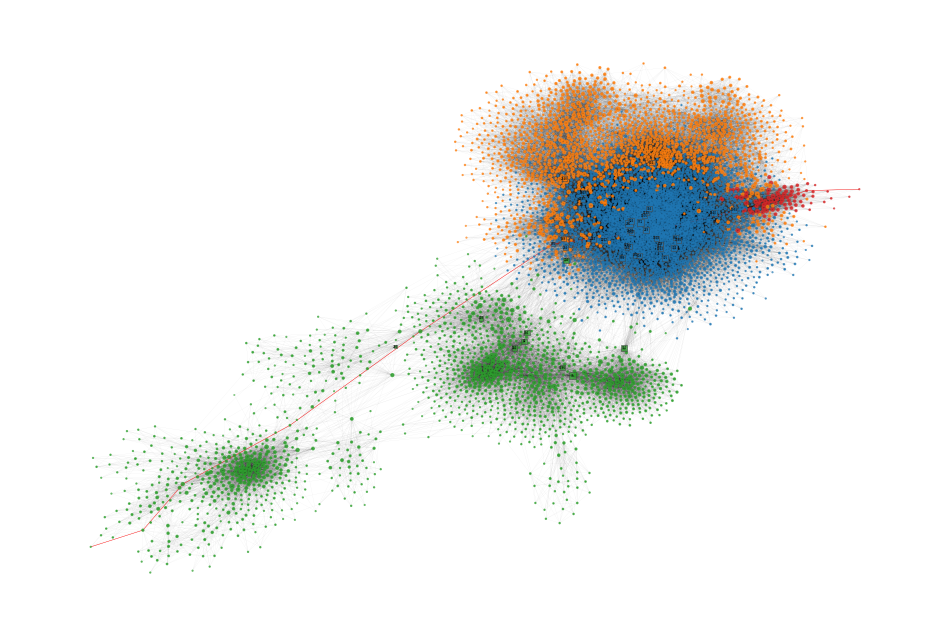

In [3180]:
plt.figure(figsize=(12, 8))
# plt.title("Network Visualization with Communities and Centrality", fontsize=16)
# plt.title("Network Visualization with Communities and Centrality", fontsize=16)
for shape in set(node_shapes.values()):  
    nodes_to_draw = [node for node in G.nodes() if node_shapes[node] == shape]
    nx.draw_networkx_nodes(
        G, pos, nodelist=nodes_to_draw, 
        node_color=[node_colors[i] for i in nodes_to_draw],  # Keep original colors
        edgecolors=[node_edge_colors[i] for i in nodes_to_draw],  # Black for top nodes, hidden for others
        linewidths=[node_linewidths[i] for i in nodes_to_draw],
        node_size=[node_sizes[i] for i in nodes_to_draw],  # Keep original sizes
        alpha=0.75,
        node_shape=shape  # Apply different shapes
    )
    
labels = {node: str(node) for node in top_50_nodes if node in G.nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=2, font_color='black')
nx.draw_networkx_edges(G, pos, alpha=0.4, width=0.025)
edges_in_diameter = [(diameter_path[i], diameter_path[i+1]) for i in range(len(diameter_path)-1)]
nx.draw_networkx_edges(G, pos, edgelist=edges_in_diameter, edge_color='red', width=.3)

plt.axis("off")
plt.savefig("figures/greedy_network_visualization.png", bbox_inches="tight", pad_inches=0.1, dpi=500)
plt.show()